In [ ]:
import torch, torchvision
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
from pylab import rcParams
import PIL.Image as Image
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
import os
from collections import defaultdict
%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -qq GTSRB_Final_Training_Images.zip

--2020-06-27 11:53:25--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  80.2MB/s    in 3.3s    

2020-06-27 11:53:28 (80.2 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



In [ ]:
train_folders = sorted(glob('GTSRB/Final_Training/Images/*'))
len(train_folders)

43

In [ ]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
  return img
def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')
def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

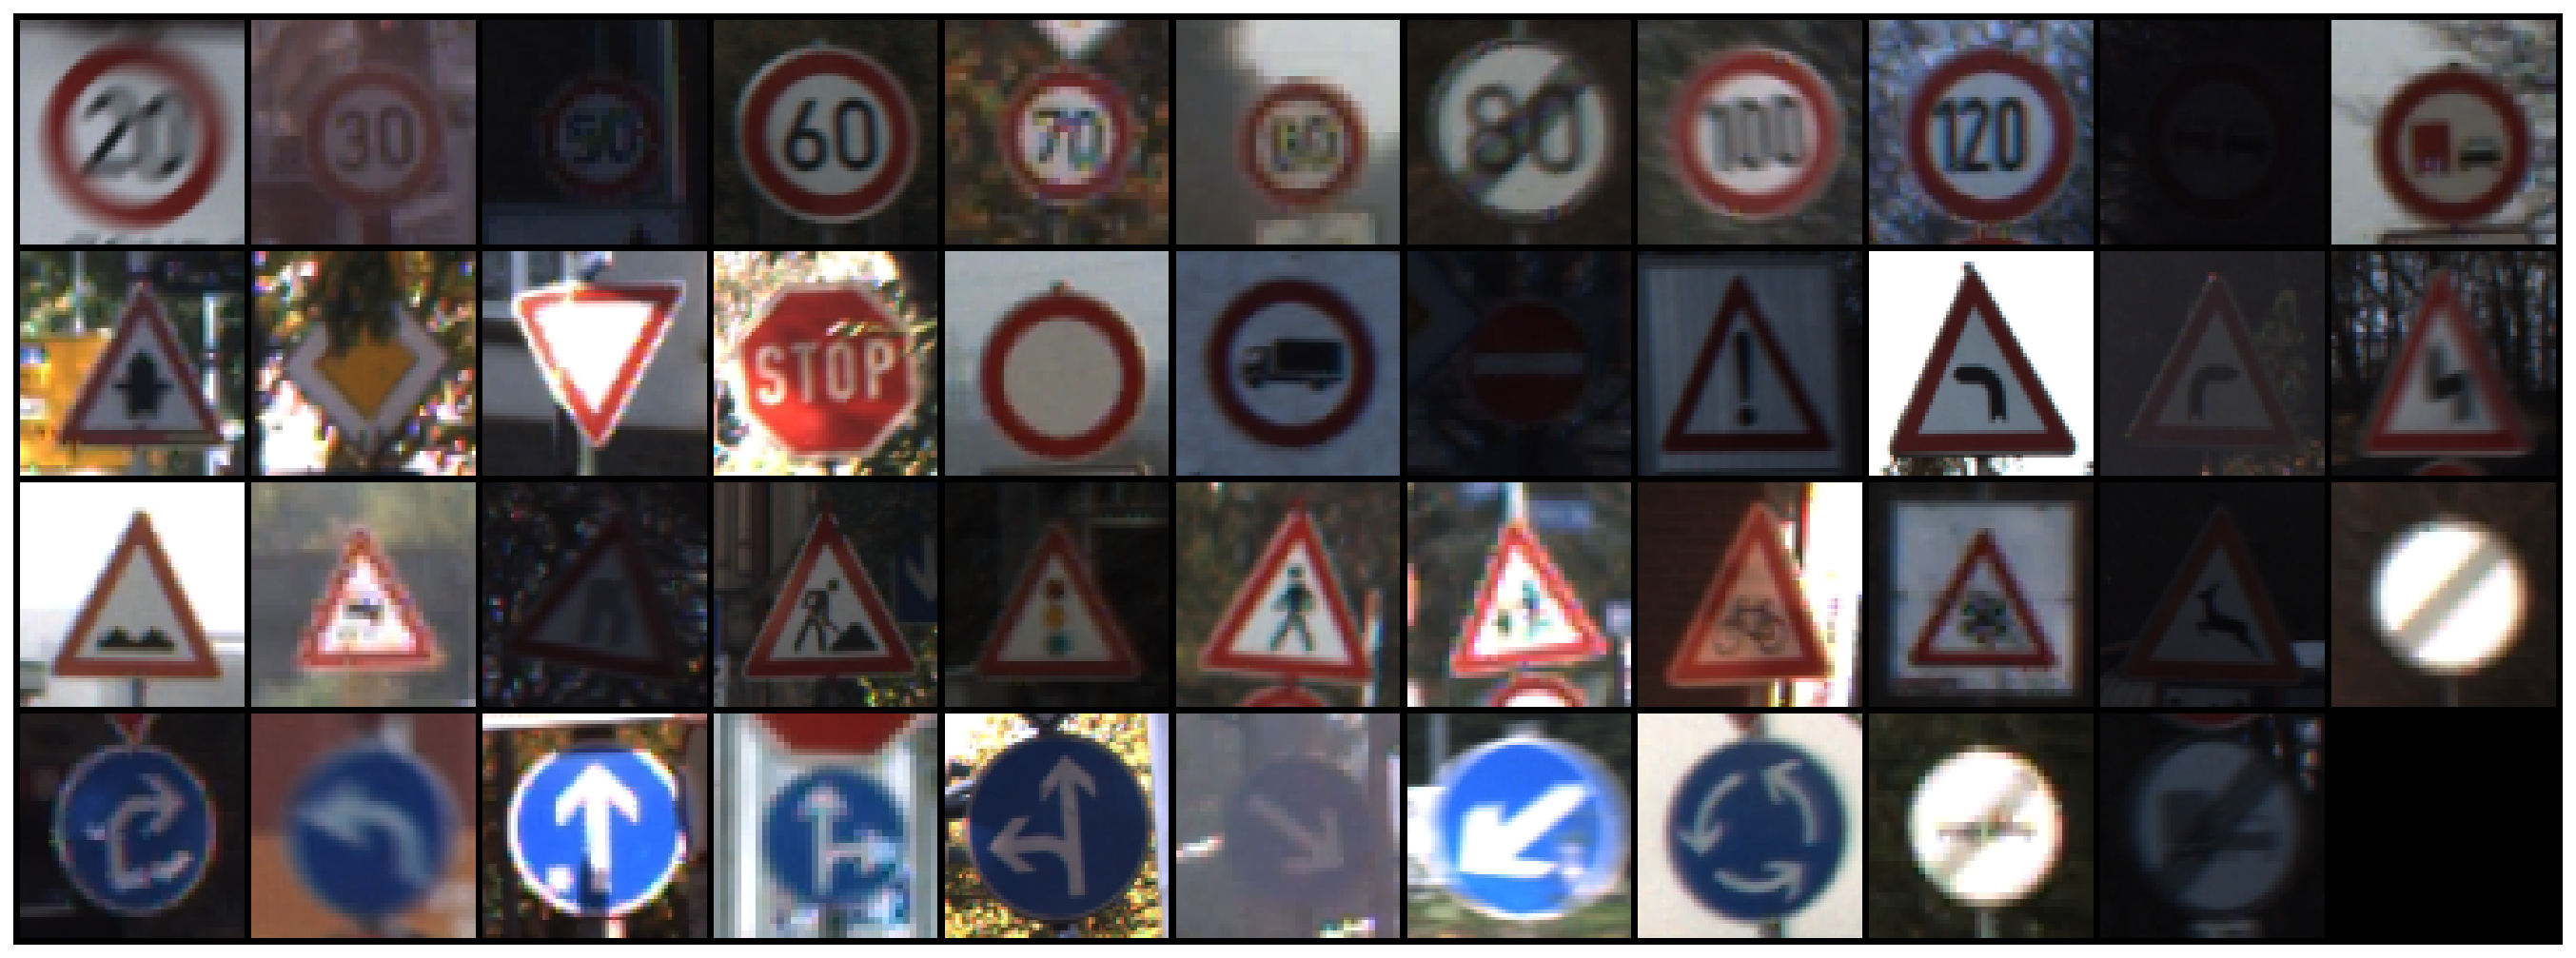

In [ ]:
sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in train_folders]
show_sign_grid(sample_images)

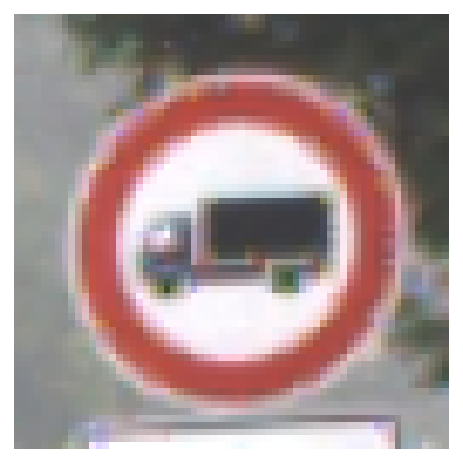

In [ ]:
img_path = glob(f'{train_folders[16]}/*ppm')[1]
show_image(img_path)

In [ ]:
class_names = ['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing veh over 3.5 tons', 'Right-of-way at intersection', 'Priority road', 'Give_way', 'Stop', 'No vehicles', 'Veh > 3.5 tons prohibited', 'No entry', 'General caution', 'Dangerous curve left', 'Dangerous curve right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End speed + passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End no passing veh > 3.5'  ]
class_indices = [*range(0,43)]

In [ ]:
!rm -rf data
DATA_DIR = Path('data')
DATASETS = ['train', 'val', 'test']
for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [ ]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)
  ds_split = np.split(
    image_paths,
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )
  dataset_data = zip(DATASETS, ds_split)
  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

Speed limit (20km/h): 210
Speed limit (30km/h): 2220
Speed limit (50km/h): 2250
Speed limit (60km/h): 1410
Speed limit (70km/h): 1980
Speed limit (80km/h): 1860
End of speed limit (80km/h): 420
Speed limit (100km/h): 1440
Speed limit (120km/h): 1410
No passing: 1470
No passing veh over 3.5 tons: 2010
Right-of-way at intersection: 1320
Priority road: 2100
Give_way: 2160
Stop: 780
No vehicles: 630
Veh > 3.5 tons prohibited: 420
No entry: 1110
General caution: 1200
Dangerous curve left: 210
Dangerous curve right: 360
Double curve: 330
Bumpy road: 390
Slippery road: 510
Road narrows on the right: 270
Road work: 1500
Traffic signals: 600
Pedestrians: 240
Children crossing: 540
Bicycles crossing: 270
Beware of ice/snow: 450
Wild animals crossing: 780
End speed + passing limits: 240
Turn right ahead: 689
Turn left ahead: 420
Ahead only: 1200
Go straight or right: 390
Go straight or left: 210
Keep right: 2070
Keep left: 300
Roundabout mandatory: 360
End of no passing: 240
End no passing veh > 

In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]
transforms = {'train': T.Compose([
  T.RandomResizedCrop(size=256),
  T.RandomRotation(degrees=15),
  T.RandomHorizontalFlip(),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [ ]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}
data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=16, shuffle=True, num_workers=4)
  for d in DATASETS
}

In [ ]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes
dataset_sizes

{'test': 3921, 'train': 31367, 'val': 3921}

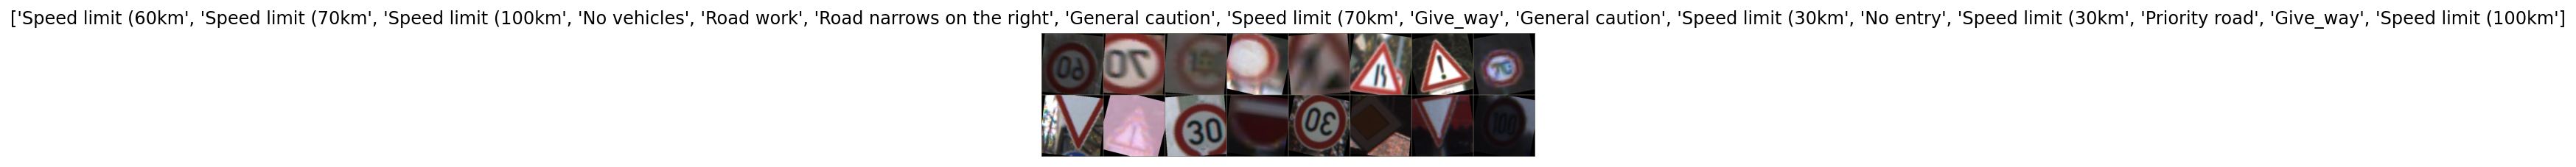

In [ ]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')
inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def create_model(n_classes):
  model = models.resnet34(pretrained=True)
  n_features = model.fc.in_features
  model.fc = nn.Linear(n_features, n_classes)
  return model.to(device)

In [ ]:
base_model = create_model(len(class_names))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  scheduler.step()
  return correct_predictions.double() / n_examples *100, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples * 100, np.mean(losses)

In [27]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=3):
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)
  history = defaultdict(list)
  best_accuracy = 0
  if os.path.isdir('checkpoints'):
    !rm -rf checkpoints/
  os.mkdir('checkpoints')
  for epoch in range(n_epochs):
    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(model,data_loaders['train'],loss_fn,optimizer,device,scheduler,dataset_sizes['train'])
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(model,data_loaders['val'],loss_fn,device,dataset_sizes['val'])
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
      best_accuracy = val_acc
      torch.save(model.state_dict(), 'checkpoints/model_A{:.7f}.pt'.format(best_accuracy))

  print(f'Best val accuracy: {best_accuracy}')
  model.load_state_dict(torch.load('checkpoints/model_A{:.7f}.pt'.format(best_accuracy)))
  return model, history

In [28]:
%%time
base_model, history = train_model(base_model, data_loaders, dataset_sizes, device,n_epochs=10)

Epoch 1/10
----------
Train loss 0.18741424852475896 accuracy 94.00006376127776
Val   loss 0.012384118345694813 accuracy 99.56643713338434

Epoch 2/10
----------
Train loss 0.18806075656948984 accuracy 93.90123378072495
Val   loss 0.019298436559312713 accuracy 99.28589645498597

Epoch 3/10
----------
Train loss 0.18301182574213068 accuracy 94.07657729460898
Val   loss 0.02205403197587021 accuracy 99.36240754909461

Epoch 4/10
----------
Train loss 0.1888089383911239 accuracy 93.90760990850255
Val   loss 0.015812886803130793 accuracy 99.54093343534812

Epoch 5/10
----------
Train loss 0.16964799721384766 accuracy 94.48783753626422
Val   loss 0.012801748708011658 accuracy 99.54093343534812

Epoch 6/10
----------
Train loss 0.16910565945033454 accuracy 94.50058979181942
Val   loss 0.014351397510466537 accuracy 99.54093343534812

Epoch 7/10
----------
Train loss 0.16323526603326938 accuracy 94.68868556125864
Val   loss 0.0057516389988302215 accuracy 99.79597041571027

Epoch 8/10
----------

In [29]:
model_name = max(os.listdir('checkpoints'))
print(model_name)

model_A99.8469778.pt


In [30]:
from google.colab import files
files.download(os.path.join('checkpoints','model_A99.8469778.pt'))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

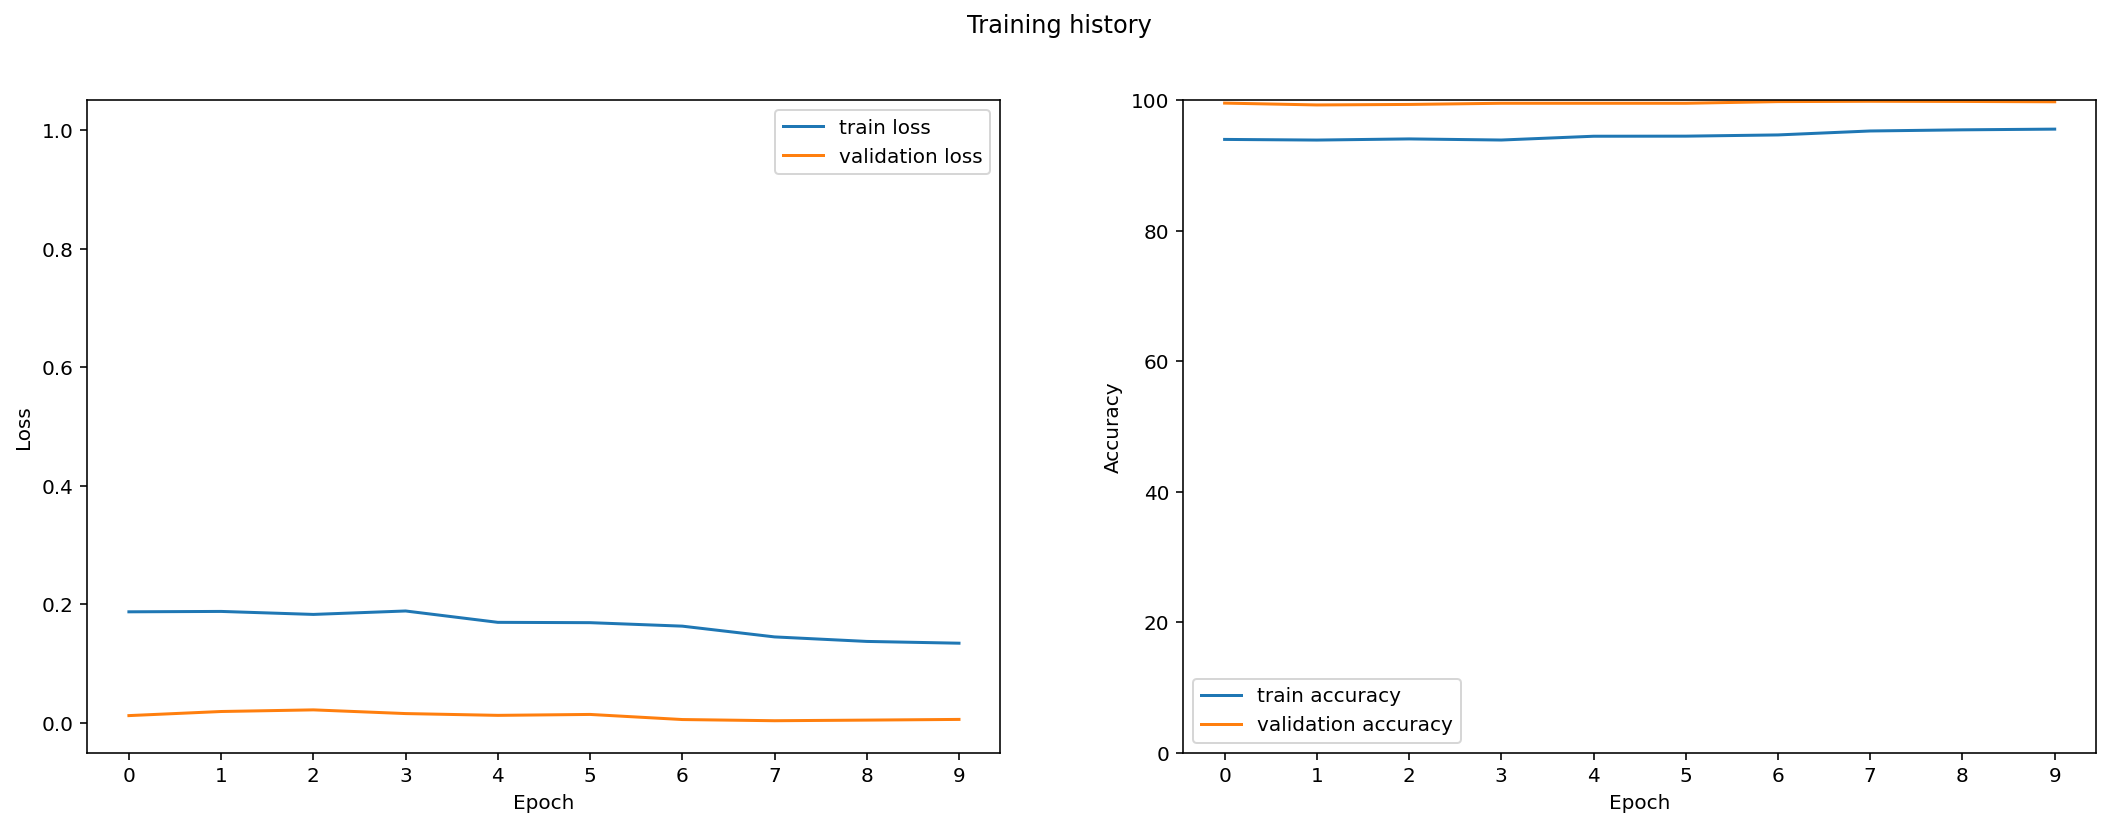

In [31]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')
  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')
  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([0, 100])
  ax2.legend()
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')
  fig.suptitle('Training history')
plot_training_history(history)

In [32]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'pred: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')
        if images_handeled == n_images:
          return

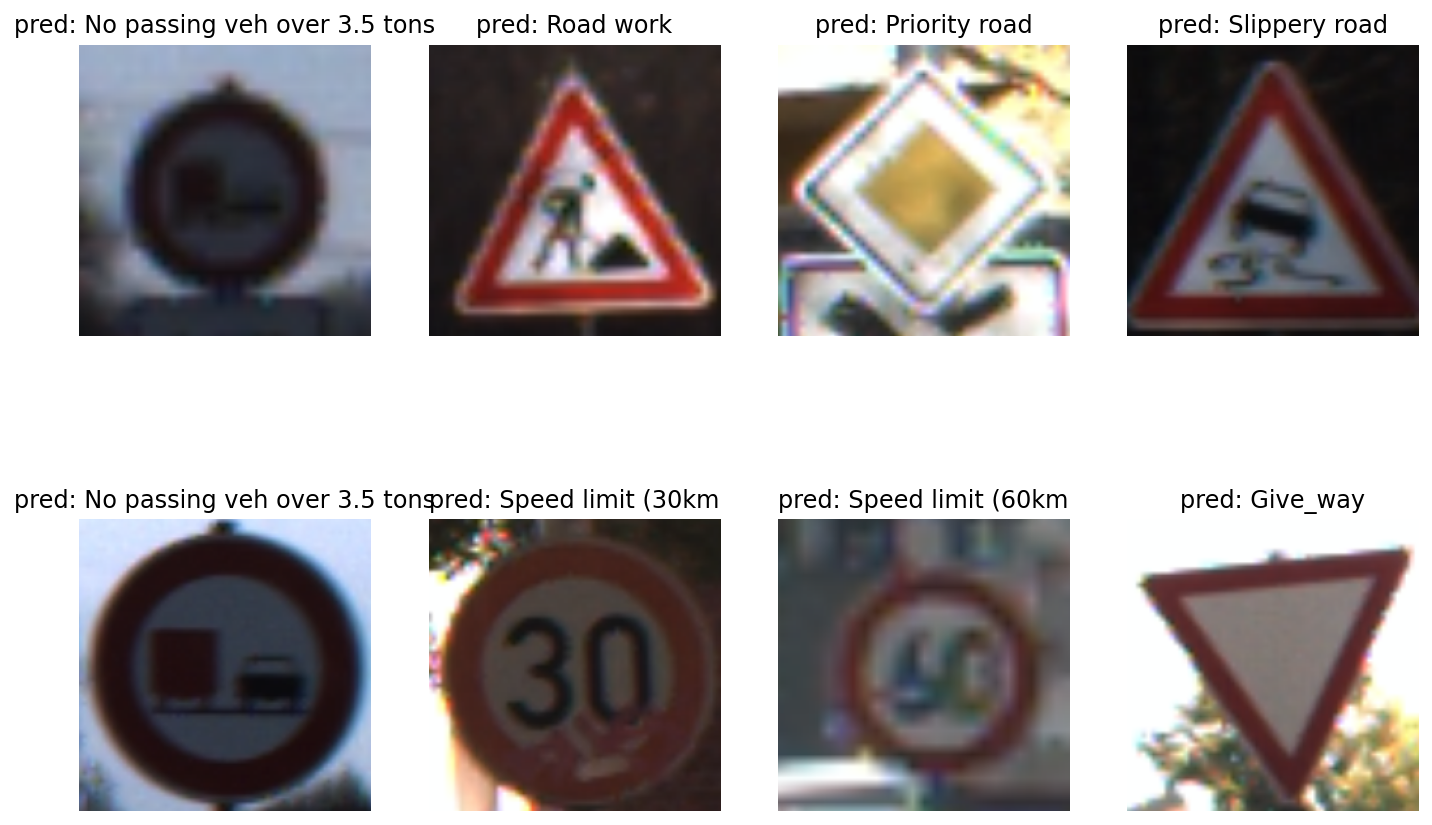

In [33]:
show_predictions(base_model, class_names, n_images=8)

In [34]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [35]:
y_pred, y_test = get_predictions(base_model, data_loaders['test'])

In [36]:
print(classification_report(y_test, y_pred, target_names=class_names))

                              precision    recall  f1-score   support

                  Ahead only       1.00      1.00      1.00       120
               Beware of ice       1.00      1.00      1.00        45
           Bicycles crossing       1.00      1.00      1.00        27
                  Bumpy road       1.00      1.00      1.00        39
           Children crossing       1.00      1.00      1.00        54
        Dangerous curve left       1.00      1.00      1.00        21
       Dangerous curve right       1.00      1.00      1.00        36
                Double curve       1.00      1.00      1.00        33
    End no passing veh > 3.5       1.00      1.00      1.00        24
           End of no passing       1.00      1.00      1.00        24
    End of speed limit (80km       1.00      1.00      1.00        42
  End speed + passing limits       1.00      1.00      1.00        24
             General caution       1.00      1.00      1.00       120
                   